In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import random
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [32]:
!pip install --upgrade pyswarm
from pyswarm import pso

Requirement already up-to-date: pyswarm in /home/vitor/anaconda3/lib/python3.8/site-packages (0.6)


In [33]:
def f_root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [34]:
def comparison_plot(y_true, y_pred):

    #Simple code to evalutate the prediction of X against y
    eixo_x=np.array(np.arange(0,y_true.size,1))

    fig, ax = plt.subplots(figsize=(16, 5))

    ax.plot(eixo_x, y_true, label='y real')
    ax.plot(eixo_x, y_pred, label='y estimado')
    ax.set_ylabel('Y(i)')
    ax.set_xlabel('i')
    ax.legend()

In [35]:
X=np.load('X.npy')
y=np.load('y.npy')

print("X.shape: {}\ny.shape: {}\n".format(X.shape, y.shape))


X.shape: (506, 13)
y.shape: (506,)



# Grid Search

A busca em _Grid_ utiliza um vetor previamente determinado com valores para cada hiperparâmetro da nossa função, e calcula um _score_ para cada combinação, salvando sempre o melhor _score_ e a combinação de hiperparâmetros que leva a ele.

In [36]:
#Generating grids
C_grid=2**(np.linspace(-5,15,5))
print("C grid is: {}".format(C_grid))

gamma_grid=2**(np.linspace(-15,3,5))
print("Gamma grid is {}".format(gamma_grid))

epsilon_grid=(np.linspace(0.05,1,5))
print("Epsilon grid is {}".format(epsilon_grid))

C grid is: [3.1250e-02 1.0000e+00 3.2000e+01 1.0240e+03 3.2768e+04]
Gamma grid is [3.05175781e-05 6.90533966e-04 1.56250000e-02 3.53553391e-01
 8.00000000e+00]
Epsilon grid is [0.05   0.2875 0.525  0.7625 1.    ]


In [37]:


# Using the Grid Seach
grid_search=GridSearchCV( SVR(kernel='rbf'), 
                          param_grid = { "C"      : C_grid, 
                                         "gamma"  : gamma_grid, 
                                         "epsilon": epsilon_grid}, 
                          scoring = 'neg_root_mean_squared_error')
grid_search.fit(X,y)
#print(grid_search)
                        

GridSearchCV(estimator=SVR(),
             param_grid={'C': array([3.1250e-02, 1.0000e+00, 3.2000e+01, 1.0240e+03, 3.2768e+04]),
                         'epsilon': array([0.05  , 0.2875, 0.525 , 0.7625, 1.    ]),
                         'gamma': array([3.05175781e-05, 6.90533966e-04, 1.56250000e-02, 3.53553391e-01,
       8.00000000e+00])},
             scoring='neg_root_mean_squared_error')

In [38]:
print("Os melhores valores de hiperparâmetros são: {}\nSeu RMSE é: {}".format(grid_search.best_params_, np.absolute(grid_search.best_score_)))

Os melhores valores de hiperparâmetros são: {'C': 32768.0, 'epsilon': 0.05, 'gamma': 3.0517578125e-05}
Seu RMSE é: 3.7825692902690755


Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:



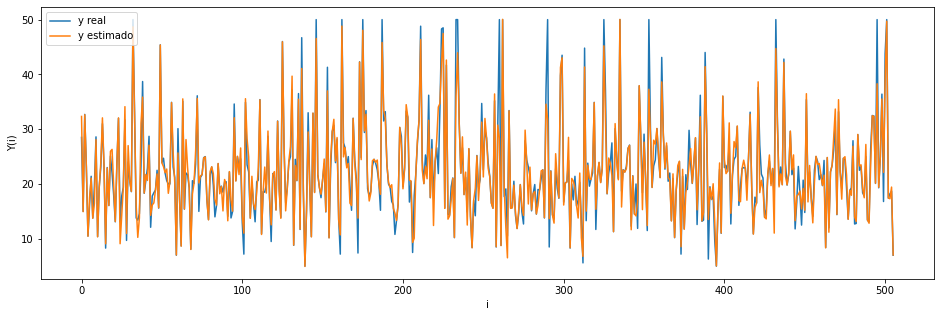

In [39]:
print("Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:\n")
comparison_plot(y,grid_search.best_estimator_.predict(X))


# PSO

O _Particle Swarm Optimization_ é um algoritmo que usa a abstração de um enxame de partículas pra encontrar o ponto ótimo. Começamos com um número $N$ de partículas, cada uma com posição e velocidade aleatória. A próxima posição ($P_{i+1}$) de uma partícula é definida pela posição atual ($P_i$) somada à velocidade atual ($Vi$), como ilustrado pela equação abaixo:

$$ X_{i+1}​=X_i​+V_i $$

As partículas compartilham entre si o melhor ponto encontrado pelo grupo, e cada uma guarda a posição do melhor ponto encontrado pela própria partícula. Essas duas informações são utilizadas para decidir a próxima velocidade. A velocidade em cada dimensão ($d$) possui um componente de momento ($\omega$) que leva em consideração a direção atual, um componente cognitivo ($\phi_1$), que escala a distância entre a posição atual ($X_{i,d}$) e o melhor ponto encontrado pela partícula ($P_{i,d}$), e uma componente social ($\phi_2$) que escala a distância para a melhor posição global ($G_d$) encontrada até o momento, como ilustrado pela equação abaixo, onde $u_1$ e $u_2$ são números aleatórios entre 0 e 1:

$$ V_{i+1,d} = \omega \times V_{i,d} + \phi_1\times u_1 \times (P_{i,d}​−X{i,d}​)+\phi_2​\times u_2 ​\times(G_d​−X{i,d}​) $$

In [40]:
#Define the objective function to be optimized. A function that receives the hiper parameters and return the RMES
def hyperparameter_evalutation_function(x):
    
    log_C     = 20*x[0] - 5
    log_gamma = 18*x[1] - 15
    epsilon_  = x[2]


    C_     = 2**log_C
    gamma_ = 2**log_gamma
    
    reg=SVR(kernel  = 'rbf',
            C       = C_,
            gamma   = gamma_,
            epsilon = epsilon_)
    
    neg_root_mean_squared_errors = cross_val_score(reg, X, y, cv=5, scoring = 'neg_root_mean_squared_error')

    # Return the absolute value, since we're seeking to minimize the function value    
    return np.absolute(np.average(neg_root_mean_squared_errors))

In [41]:
def normalize_C(C_):
    return (np.log2(C_) + 5)/20
def unnormalize_C (C_):
    return 2**(20 * C_ - 5)

def normalize_gamma(gamma_):
    return (np.log2(gamma_) + 15)/18
def unnormalize_gamma(gamma_):
    return 2**(18 * gamma_ - 15)


In [42]:
# hyperparameter_evalutation_function self test! 
# Result should match the grid seach iteration
# For C: 32768.0, 'gamma': 3.0517578125e-05, 'epsilon': 0.05
# The result should be -3.7825692902690755

test_hyperparameter_evalutation_function_val = hyperparameter_evalutation_function([normalize_C(32768), normalize_gamma(3.0517578125e-05), 0.05])
print(test_hyperparameter_evalutation_function_val)

3.7825692902690755


In [43]:
# Optimizing the function using PSO:
#                        C,    gamma  epsilon
pso_lower_boundaries = [0.0,   0.0,    0.05]
pso_upper_boundaries = [1.0,   1.0,    1.0]

pso_best_x, pso_best_averaged_rmes = pso(func      = hyperparameter_evalutation_function,
                                         lb        = pso_lower_boundaries, 
                                         ub        = pso_upper_boundaries,
                                         swarmsize = 11,
                                         maxiter   = 11)

print("Os melhores valores de hiperparâmtros são:\nC      : {}\ngamma  : {}\nepsilon: {}\nRMES   : {}".format(unnormalize_C(pso_best_x[0]), 
                                                                                                              unnormalize_gamma(pso_best_x[1]), 
                                                                                                              pso_best_x[2], 
                                                                                                              pso_best_averaged_rmes))



Stopping search: maximum iterations reached --> 11
Os melhores valores de hiperparâmtros são:
C      : 19949.306730947057
gamma  : 3.0517578125e-05
epsilon: 0.18683495609204026
RMES   : 3.7268219027510865


In [44]:
#Quick Test with the values found
test_hyperparameter_evalutation_function_val = hyperparameter_evalutation_function([pso_best_x[0], pso_best_x[1], pso_best_x[2]])
print(test_hyperparameter_evalutation_function_val)

3.7268219027510865


Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:



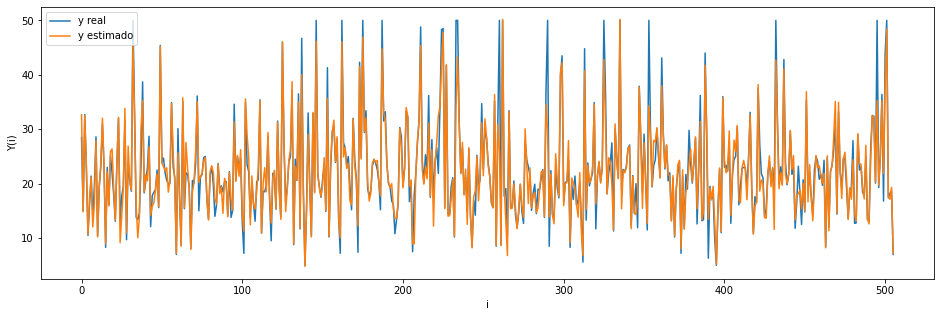

In [45]:
print("Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:\n")
comparison_plot(y,
SVR(kernel  = 'rbf',
    C       = unnormalize_C(pso_best_x[0]),
    gamma   = unnormalize_gamma(pso_best_x[1]), 
    epsilon = pso_best_x[2]).fit(X,y).predict(X)
    )

Observa-se que o desempenho do algoritmo e otimização foi próximo ao $Grid Search$, obtendo um erro marginalmente menor.

# Simulated Annealing

O método _Simulated Annealing_ se baseia no funcionamento de uma têmpera. A partir de uma posição inicial na função, um novo ponto é gerado, e o valor da função desse ponto é comparado com o ponto inicial. Se a função diminuiu, o novo ponto passa a ser o valor ótimo atual. Se a função aumentou, a probabilidade de que este novo ponto vire o ponto atual é dado pela equação abaixo: 

$$ P=e^{(f(y)−f(x))/T} $$

Onde $T$ é uma variável temperatura que decrementa a medida que as iterações avançam. $T$ deve começar um valor alto (cerca de 98% no algoritmo utilizado), dessa forma $P \approx e^0=1$ no início do algoritmo, o que aumenta a exploração do algoritmo no espaço de estados possíveis. A medida que o tempo passa, T decrementa, diminuindo a probabilidade de que um novo ponto seja aceito, até que o algoritmo estabiliza e o último estado é retornado.

In [46]:
! pip install simanneal  # from pypi

In [47]:

# Test the implementation with max and min values of the scalonation
# MAX
test_svr_max_val=SVR(kernel  = 'rbf',
                     C       = 2**15,
                     gamma   = 2**3,
                     epsilon = 1)
max_val_root_mean_squared_errors = np.absolute(np.average(cross_val_score(test_svr_max_val, X, y, cv=5, scoring = 'neg_root_mean_squared_error')))
test_hyperparameter_evalutation_function_max_val = hyperparameter_evalutation_function([1,1,1])
print(max_val_root_mean_squared_errors)
print(test_hyperparameter_evalutation_function_max_val)


test_svr_min_val=SVR(kernel  = 'rbf',
                     C       = 2**(-5),
                     gamma   = 2**(-15),
                     epsilon = 0)
# MIN
min_val_root_mean_squared_errors = np.absolute(np.average(cross_val_score(test_svr_min_val, X, y, cv=5, scoring = 'neg_root_mean_squared_error')))
test_hyperparameter_evalutation_function_min_val = hyperparameter_evalutation_function([0,0,0])
print(min_val_root_mean_squared_errors)
print(test_hyperparameter_evalutation_function_min_val)


9.154837321512684
9.154837321512684
8.800089594945915
8.800089594945915


In [52]:
# Create the class that inherits from Annealer
import simanneal
from simanneal import Annealer

class SvmRegressorSimulatedAnnealing(Annealer):
    """Simulated Annealing optimization for SVM Regressor hyperparameters finding."""
        
    # pass extra data into the constructor
    def __init__(self, state, objective_function, step_range):
        self.objective_function = hyperparameter_evalutation_function
        self.step_range         = step_range
        super(SvmRegressorSimulatedAnnealing, self).__init__(state)
    
    def energy(self):
        """Calculate the RMES of current hyperparameters."""
        e = self.objective_function(self.state)
        return e

    def increase_and_check_boundaries(self, current_state):
        """Increase state using step_range and check boundaries"""
        next_state = current_state + random.uniform(self.step_range[0], self.step_range[1])
        
        if(next_state < 0.0):
            return 0.0
        elif (next_state > 1.0):
            return 1.0
        else: 
            return next_state

    def move(self):
        """Calculate next hyperparameter values"""
        for i in range(3):
            self.state[i] = self.increase_and_check_boundaries(self.state[i])
        

In [49]:
import math

# Defining the maximum and minimum temperatures
# Generate random points and get the average difference between them
output_list = []
for i in range(300):
    output_list.append(hyperparameter_evalutation_function([random.uniform(0,1), random.uniform(0,1), random.uniform(0,1),]))
np_output_list=np.array(output_list)

np_function_diferences = np_output_list-np.average(np_output_list)

np_average_difference  = np.average(np.abs(np_function_diferences))
sa_maximum_temperature = -np_average_difference/math.log(0.98)
print("Tmax is {}".format(sa_maximum_temperature))

Tmax is 65.36489817244163


In [53]:
# Run the simualted annealing algorithm
sa_initial_state = [0.5, 0.5, 0.5]
sa_step_range    = [-0.02, 0.02]

sa_svm_regressor = SvmRegressorSimulatedAnnealing(sa_initial_state, hyperparameter_evalutation_function, sa_step_range)

sa_svm_regressor.steps = 125
sa_svm_regressor.updates=10
sa_svm_regressor.Tmax  = sa_maximum_temperature
sa_svm_regressor.Tmin  = 0.001

# Run it!
sa_best_hyperparams, sa_best_rmes = sa_svm_regressor.anneal()

print("\nOs melhores valores de hiperparâmtros são:\nC      : {}\ngamma  : {}\nepsilon: {}\nRMES   : {}".format(unnormalize_C(sa_best_hyperparams[0]), 
                                                                                                              unnormalize_gamma(sa_best_hyperparams[1]), 
                                                                                                              sa_best_hyperparams[2], 
                                                                                                              sa_best_rmes))


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100          5.41    25.00%    25.00%     0:00:10     0:00:00
Os melhores valores de hiperparâmtros são:
C      : 29.246439609690775
gamma  : 0.0017865852573118398
epsilon: 0.5095642910358181
RMES   : 5.409025509621417


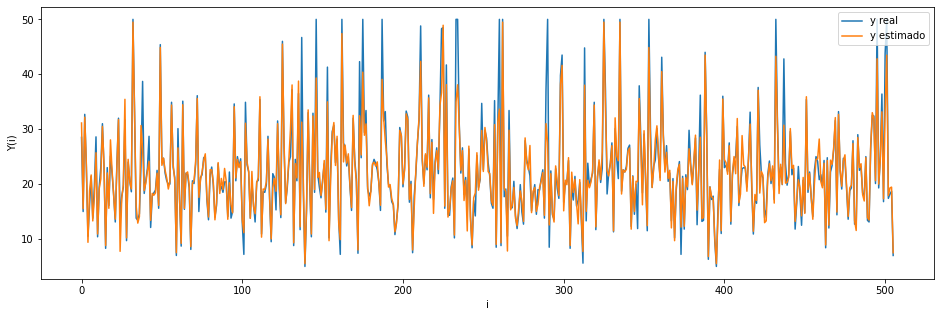

In [58]:
comparison_plot(y,
SVR(kernel  = 'rbf',
    C       = unnormalize_C(sa_best_hyperparams[0]),
    gamma   = unnormalize_gamma(sa_best_hyperparams[1]), 
    epsilon = sa_best_hyperparams[2]).fit(X,y).predict(X)
    )

Utilizando os hiperparâmetros recomendados pelo enunciado, o desempenho do algoritmo de Têmpera Simulada foi inferior aos anteriores, retornando um erro 45% maior que a média dos demais.

É possível observar que a taxa de aceite ainda estava muito alta quando o algoritmo parou, o que indica que com mais rodadas se poderia chegar em melhores resultados. Fazendo uma nova rodada com passo maior (0,04 em vez de 0,02) e mais iterações (400 em vez de 125), obtem-se um resultado bastante próximo ao dos algoritmos anteriores, como mostrado a seguir.

In [54]:
# Run the simualted annealing algorithm
sa2_initial_state = [0.5, 0.5, 0.5]
sa2_step_range    = [-0.04, 0.04]
sa2_svm_regressor = SvmRegressorSimulatedAnnealing(sa2_initial_state, hyperparameter_evalutation_function, sa2_step_range)
sa2_svm_regressor.steps = 400
sa2_svm_regressor.updates=10
sa2_svm_regressor.Tmax  = sa_maximum_temperature
sa2_svm_regressor.Tmin  = 0.001

# Run it!
sa2_best_hyperparams, sa2_best_rmes = sa2_svm_regressor.anneal()

print("\nOs melhores valores de hiperparâmtros são:\nC      : {}\ngamma  : {}\nepsilon: {}\nRMES   : {}".format(unnormalize_C(sa2_best_hyperparams[0]), 
                                                                                                              unnormalize_gamma(sa2_best_hyperparams[1]), 
                                                                                                              sa2_best_hyperparams[2], 
                                                                                                              sa2_best_rmes))


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100          3.80    10.00%     7.50%     0:05:06     0:00:00
Os melhores valores de hiperparâmtros são:
C      : 11670.971043096564
gamma  : 3.0517578125e-05
epsilon: 0.7067551267378444
RMES   : 3.7991929038681556


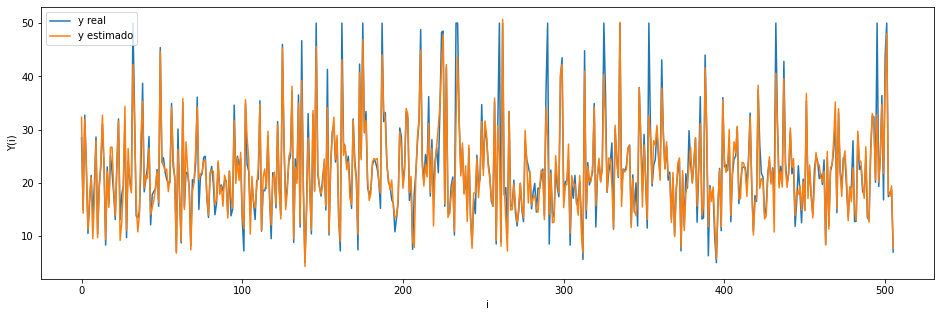

In [59]:
comparison_plot(y,
SVR(kernel  = 'rbf',
    C       = unnormalize_C(sa2_best_hyperparams[0]),
    gamma   = unnormalize_gamma(sa2_best_hyperparams[1]), 
    epsilon = sa2_best_hyperparams[2]).fit(X,y).predict(X)
    )